In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import hdbscan

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [3]:
import numpy as np

data_train = np.loadtxt("ECG5000_TRAIN.txt", delimiter=",")

data_test = np.loadtxt("ECG5000_TEST.txt", delimiter=",")

data_joined = np.concatenate((data_train,data_test),axis=0)
data_train, data_test = train_test_split(data_joined, 
                                    test_size=0.20, random_state=2019)

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [4]:
# Summary statistics
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [5]:
# Calculate number of readings per class
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))
print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))
print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))
print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2327
Number of time series in class 2.0: 1423
Number of time series in class 3.0: 75
Number of time series in class 4.0: 156
Number of time series in class 5.0: 19


 Class  1.0  Count  2327


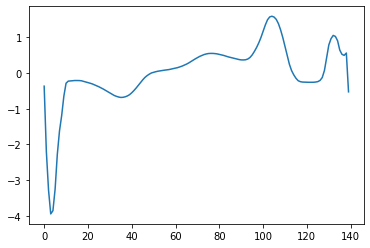

 Class  2.0  Count  1423


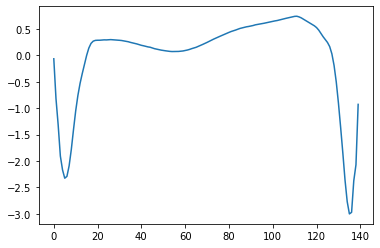

 Class  3.0  Count  75


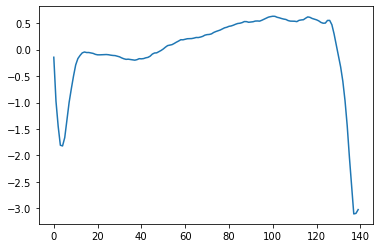

 Class  4.0  Count  156


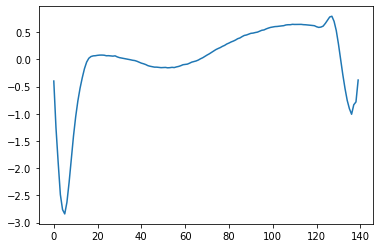

 Class  5.0  Count  19


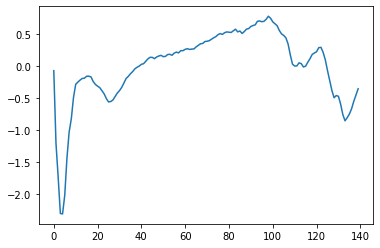

In [6]:
# Display readings from each class
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

In [7]:
# Prepare data - Scale
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [8]:
# Train model and evaluate on training set
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples, alpha=alpha, \
                      cluster_selection_method=cluster_selection_method, \
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7628260922190984


In [12]:
len(preds)

4000

In [13]:
len(data_train[:,0])

4000

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


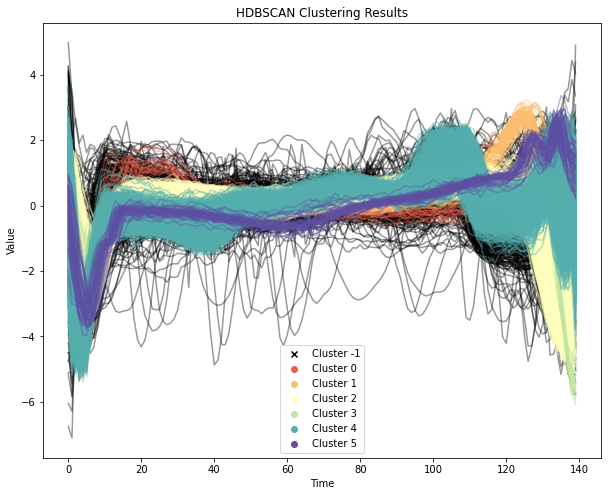

In [19]:
# クラスタリング結果をプロットする
unique_labels = np.unique(preds)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 8))

for label, color in zip(unique_labels, colors):
    if label == -1:  # ノイズの場合
        color = 'k'  # 黒色でプロット
        marker = 'x'
    else:
        marker = 'o'
    
    # 対応するクラスタのデータを取得してプロット
    mask = preds == label
    for series in X_train[mask]:
        plt.plot(series.ravel(), color=color, alpha=0.4)
        
    plt.scatter([], [], color=color, label=f'Cluster {label}', marker=marker)

plt.title('HDBSCAN Clustering Results')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2

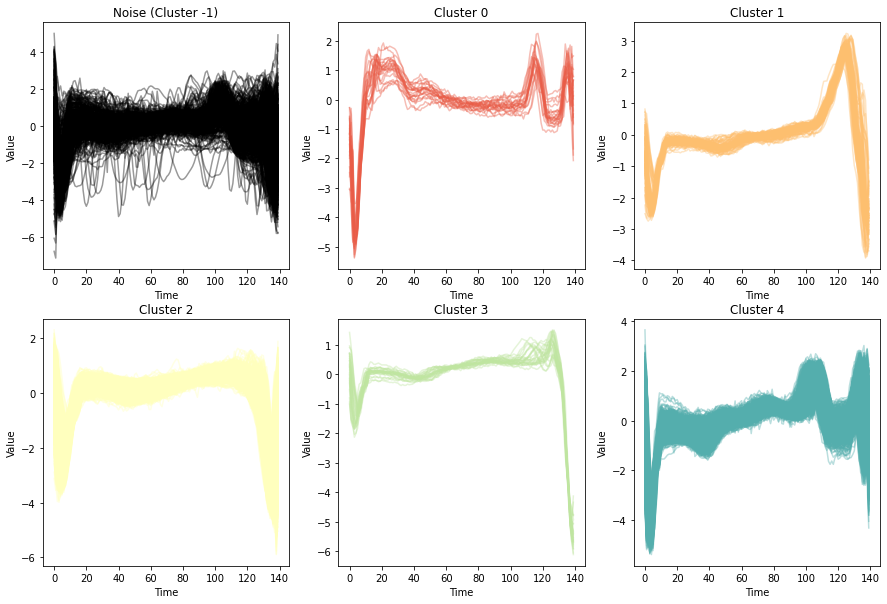

In [22]:
# クラスタリング結果をクラスタごとに2x3レイアウトでプロットする
unique_labels = np.unique(preds)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# 2x3のグリッドレイアウトを作成
num_clusters = len(unique_labels)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# クラスタごとにプロットする
for i, (label, color) in enumerate(zip(unique_labels, colors)):
    row = i // cols  # 列数で割って行を決定
    col = i % cols   # 列を決定
    
    ax = axes[row, col]  # 2x3のサブプロットを取得
    
    if label == -1:
        color = 'k'  # ノイズは黒でプロット
        title = "Noise (Cluster -1)"
    else:
        title = f"Cluster {label}"
    
    # クラスタに属する時系列データをプロット
    mask = preds == label
    for series in X_train[mask]:
        ax.plot(series.ravel(), color=color, alpha=0.4)
    
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# 空のプロットを削除（もしクラスタ数が6未満の場合）
if num_clusters < rows * cols:
    for j in range(num_clusters, rows * cols):
        fig.delaxes(axes.flatten()[j])

# レイアウトの調整
plt.tight_layout()
plt.show()
